# Compute derivatives and some stuff via Fourier transform

This code illustrates how to compute derivatives of potential-field data via Fourier transform.

### Things we have to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from gravmag import constants as ct
from gravmag.models import rectangular_prism as rp
from gravmag import filters, convolve, transforms, utils
from gravmag import plot_functions as plf

### Model

In [3]:
# Create a model formed by prisms
model = np.array([[2000., 3000., -1500., -500., 10., 1010.], 
                  [1600., 2600., -2500., -1500., 10., 1010.], 
                  [-1000., 1000., 1500, 2500, 10., 1010.],
                  [-3000., -2000., 1000, 3500., 10., 1010.]])

# magnetization of each prism
# first, second and third columns contain
# the magnetization intensity (in A/m), inclination 
# and declination (in degrees) of the sources
inc, dec = 35, -45
sigma = 1.3
magnetization = np.array([[sigma, inc, dec],
                          [sigma, inc, dec],
                          [sigma, inc, dec],
                          [sigma, inc, dec]])

# density of each prism in kg/m³ = 1e-3 g/cm³
rho = 2000.
density = np.array([rho, rho, rho, rho]) # 2000 kg/m³ = 2 g/cm³

### Points were we compute the synthetic data

In [4]:
# number of points along x and y
shape = (60, 60)

# minimum x, maximum x, minimum y and maximum y
area = [-5000, 5000, -4000, 6000]

# coordinates 
xp = np.linspace(area[0], area[1], shape[0])
yp = np.linspace(area[2], area[3], shape[1])
yp, xp = np.meshgrid(yp, xp)
yp = np.ravel(yp)
xp = np.ravel(xp)
zp = np.zeros_like(yp) - 150

coordinates = np.vstack([xp, yp, zp])

### Potential fields produced by the model

In [5]:
# gravitational potential
U = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_potential') 

# gravitational acceleration components
gx = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_x')
gy = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_y')
gz = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_z')

# second derivatives (gradient tensor components)
gxx = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_xx')
gxy = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_xy')
gxz = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_xz')
gyy = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_yy')
gyz = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_yz')
gzz = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_zz')

In [6]:
# magnetic scalar potential
V = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_potential')

# magnetic field components
bx = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_x')
by = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_y')
bz = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_z')

### Potential field obtained via Fourier transform

In [7]:
# Grid spacing
dx = (area[1] - area[0])/(shape[0]-1)
dy = (area[3] - area[2])/(shape[1]-1)

# 2D Fourier transform of the gravitational potential with a
# linear ramp padding
FT_U = transforms.DFT(data=U.reshape(shape), pad_mode='linear_ramp')

# compute wavenumbers
kx, ky, kz = transforms.wavenumbers(FT_U.shape, dx, dy)

In [8]:
# gravitational acceleration components

components = [['x'], ['y'], ['z']]

g_estimated = []

for component in components:
    # compute the scaled derivative filter in Fourier domain
    # then compute the convolution in Fourier domain
    # finally transform convolved data to space domain
    derivative_filter = ct.SI2MGAL*filters.derivative(kx, ky, kz, component)
    g_estimated.append(
        transforms.IDFT(
            FT_data=convolve.compute(
                FT_data=FT_U, 
                filters=[derivative_filter]
            ), 
            unpad=True, 
            grid=False
        )
    )

In [9]:
# gravitational tensor components

components = [['x', 'x'], ['x', 'y'], ['x', 'z'], ['y', 'y'], ['y', 'z'], ['z', 'z']]

g_tensor_estimated = []

for component in components:
    # compute the scaled derivative filter in Fourier domain
    # then compute the convolution in Fourier domain
    # finally transform convolved data to space domain
    derivative_filter = ct.SI2EOTVOS*filters.derivative(kx, ky, kz, component)
    g_tensor_estimated.append(
        transforms.IDFT(
            FT_data=convolve.compute(
                FT_data=FT_U, 
                filters=[derivative_filter]
            ), 
            unpad=True, 
            grid=False
        )
    )

In [10]:
# magnetic scalar potential

poisson_ratio = (ct.CM * sigma) / (ct.GRAVITATIONAL_CONST * rho)

# compute the scaled derivative filter in Fourier domain
# then compute the convolution in Fourier domain
# finally transform convolved data to space domain
derivative_filter = [-ct.T2MT*poisson_ratio*filters.direction(kx, ky, kz, inc, dec)]

mag_potential_estimated = [
    transforms.IDFT(
        FT_data=convolve.compute(
            FT_data=FT_U, 
            filters=derivative_filter
        ), 
        unpad=True, 
        grid=False
    )
]

In [11]:
# magnetic induction field components

components = [['x'], ['y'], ['z']]

b_estimated = []    

for component in components:
    # compute the scaled derivative filter in Fourier domain
    # then compute the convolution in Fourier domain
    # finally transform convolved data to space domain
    derivative_filter = [
        -poisson_ratio*filters.direction(kx, ky, kz, inc, dec), 
        -ct.T2NT*filters.derivative(kx, ky, kz, component)
    ]
    b_estimated.append(
        transforms.IDFT(
            FT_data=convolve.compute(
                FT_data=FT_U, 
                filters=derivative_filter
            ), 
            unpad=True, 
            grid=False
        )
    )

### Plot the results

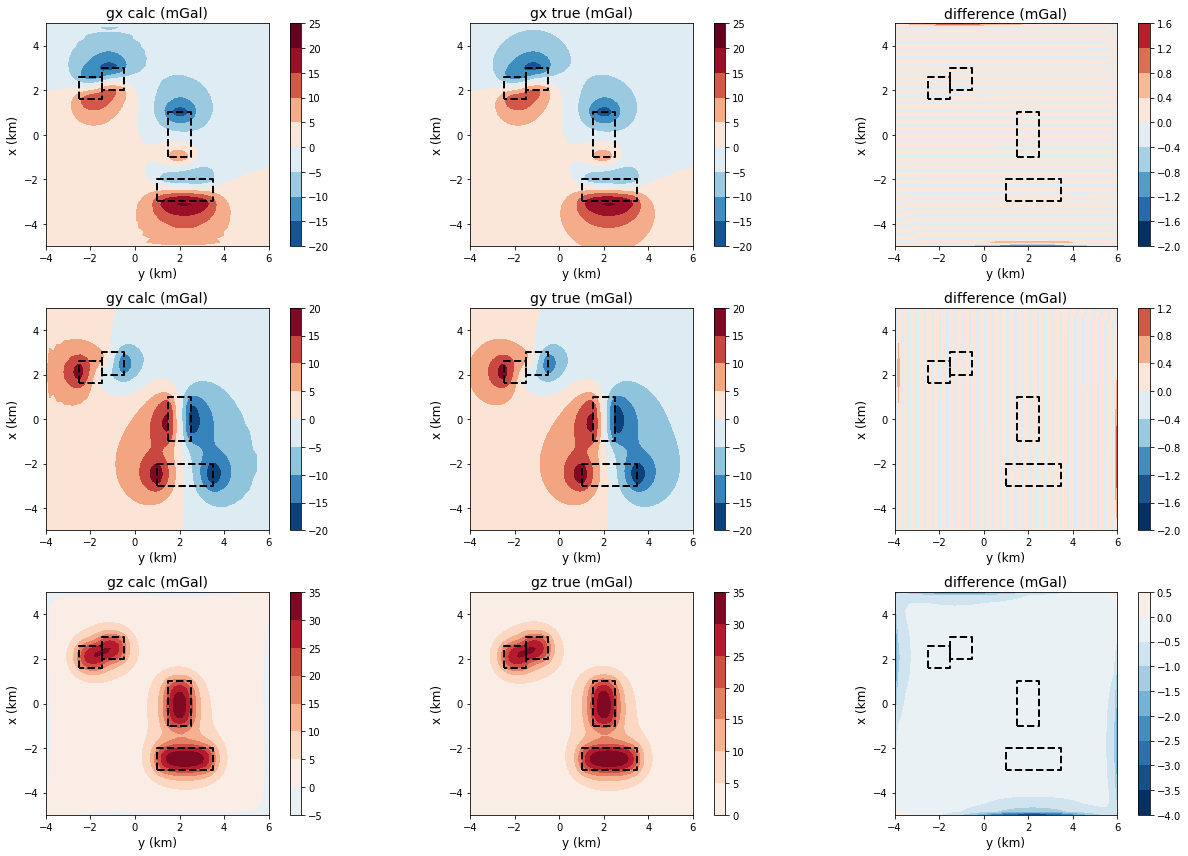

In [12]:
true_fields = [gx, gy, gz]

bounds, diffs = plf.bounds_diffs(g_estimated, true_fields)

fields = plf.fields_list(g_estimated, true_fields, diffs)

titles = [
    'gx calc (mGal)', 'gx true (mGal)', 'difference (mGal)',
    'gy calc (mGal)', 'gy true (mGal)', 'difference (mGal)',
    'gz calc (mGal)', 'gz true (mGal)', 'difference (mGal)'
]

windows = [1, 2, 3, 4, 5, 6, 7, 8, 9]

plt.figure(figsize=(18,12))

for w, window in enumerate(windows):

    plt.subplot(3,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        yp.reshape(shape)*0.001, 
        xp.reshape(shape)*0.001, 
        fields[w].reshape(shape), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

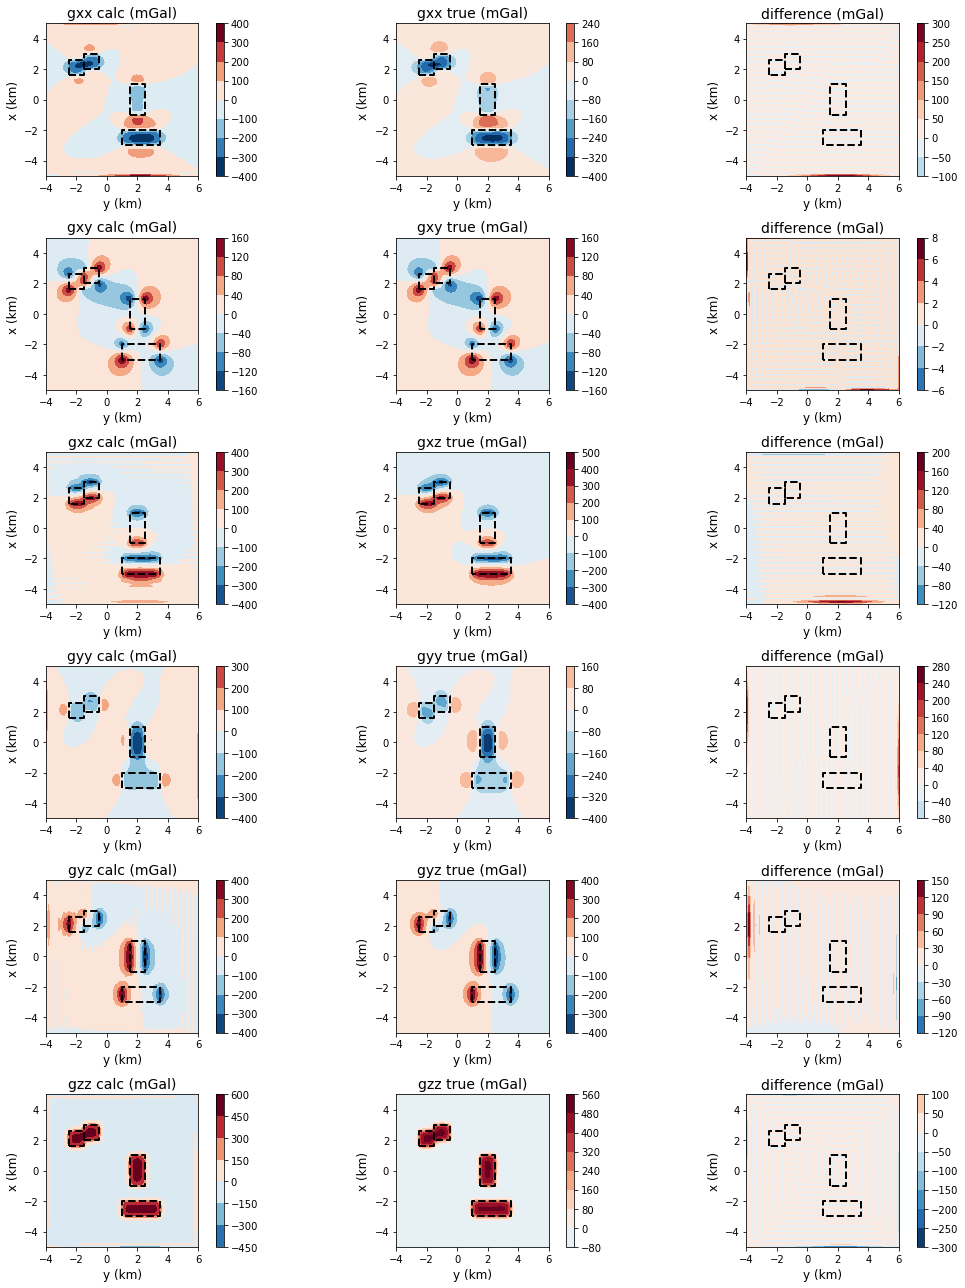

In [13]:
true_fields = [gxx, gxy, gxz, gyy, gyz, gzz]

bounds, diffs = plf.bounds_diffs(g_tensor_estimated, true_fields)

fields = plf.fields_list(g_tensor_estimated, true_fields, diffs)

titles = [
    'gxx calc (mGal)', 'gxx true (mGal)', 'difference (mGal)',
    'gxy calc (mGal)', 'gxy true (mGal)', 'difference (mGal)',
    'gxz calc (mGal)', 'gxz true (mGal)', 'difference (mGal)',
    'gyy calc (mGal)', 'gyy true (mGal)', 'difference (mGal)',
    'gyz calc (mGal)', 'gyz true (mGal)', 'difference (mGal)',
    'gzz calc (mGal)', 'gzz true (mGal)', 'difference (mGal)'
]

windows = [i for i in range(1, 19)]

plt.figure(figsize=(15,18))

for w, window in enumerate(windows):

    plt.subplot(6,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        yp.reshape(shape)*0.001, 
        xp.reshape(shape)*0.001, 
        fields[w].reshape(shape), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

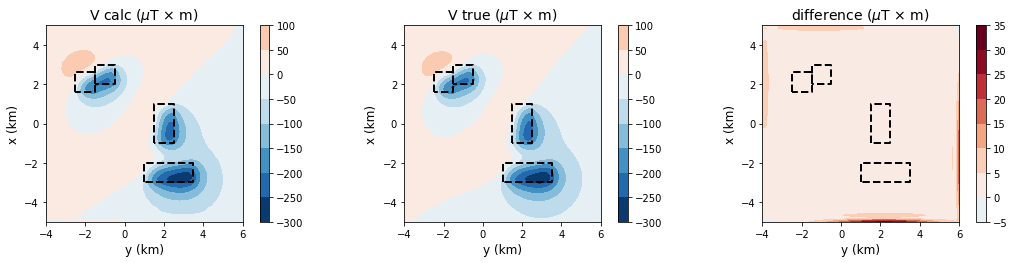

In [14]:
true_fields = [V]

bounds, diffs = plf.bounds_diffs(mag_potential_estimated, true_fields)

fields = plf.fields_list(mag_potential_estimated, true_fields, diffs)

titles = [
    'V calc ($\mu$T $\\times$ m)', 
    'V true ($\mu$T $\\times$ m)', 
    'difference ($\mu$T $\\times$ m)'
]

windows = [1, 2, 3]

plt.figure(figsize=(15,10))

for w, window in enumerate(windows):

    plt.subplot(3,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        yp.reshape(shape)*0.001, 
        xp.reshape(shape)*0.001, 
        fields[w].reshape(shape), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

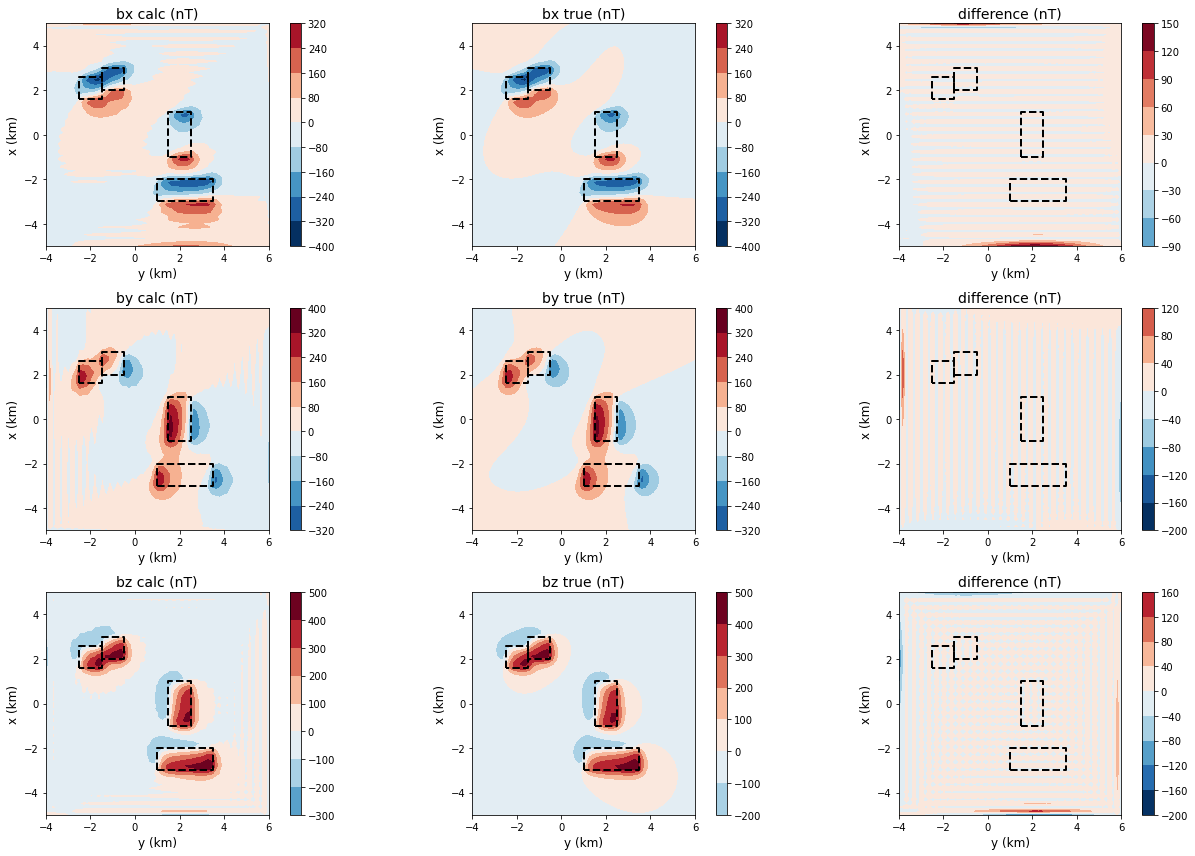

In [15]:
true_fields = [bx, by, bz]

bounds, diffs = plf.bounds_diffs(b_estimated, true_fields)

fields = plf.fields_list(b_estimated, true_fields, diffs)

titles = [
    'bx calc (nT)', 'bx true (nT)', 'difference (nT)',
    'by calc (nT)', 'by true (nT)', 'difference (nT)',
    'bz calc (nT)', 'bz true (nT)', 'difference (nT)'
]

windows = [1, 2, 3, 4, 5, 6, 7, 8, 9]

plt.figure(figsize=(18,12))

for w, window in enumerate(windows):

    plt.subplot(3,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        yp.reshape(shape)*0.001, 
        xp.reshape(shape)*0.001, 
        fields[w].reshape(shape), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()